In [1]:
from typing import *

import graphlib2
import graphlib

from matplotlib import pyplot as plt
import timeit
import statistics
import networkx as nx
import functools

In [2]:
TopologicalSorter = Union[graphlib.TopologicalSorter, graphlib2.TopologicalSorter]
Graph = Dict[int, List[int]]

In [3]:
@functools.lru_cache
def _get_linear_graph(n: int) -> Dict[int, List[int]]:
    graph: Dict[int, List[int]] = {}
    i = 0
    for i in range(n):
        graph[i] = [i+1]  # node 0 depends on node 1, etc.
    graph[i+1] = []  # node n has no dependencies
    return graph

def get_linear_graph(n: int) -> Dict[int, List[int]]:
    return {k: v.copy() for k, v in _get_linear_graph(n).items()}

@functools.lru_cache
def _get_random_graph(n: int) -> Dict[int, List[int]]:
    G = nx.fast_gnp_random_graph(n, 0.5, seed=42, directed=True)
    DAG = nx.DiGraph([(u, v) for (u, v) in G.edges() if u < v])
    return nx.convert.to_dict_of_lists(DAG)

def get_random_graph(n: int) -> Dict[int, List[int]]:
    return {k: v.copy() for k, v in _get_random_graph(n).items()}

In [4]:
def run(t: TopologicalSorter) -> None:
    to_remove = t.get_ready()
    while t.is_active():
        t.done(*to_remove)
        to_remove = t.get_ready()


def setup_rust(n: int, graph_gen: Callable[[int], Graph]) -> TopologicalSorter:
    t = graphlib2.TopologicalSorter(graph_gen(n))
    t.prepare()
    return t


def setup_python(n: int, graph_gen: Callable[[int], Graph]) -> TopologicalSorter:
    t = graphlib.TopologicalSorter(graph_gen(n))
    t.prepare()
    return t

In [5]:
glbls = {
    "setup_python": setup_python,
    "setup_rust": setup_rust,
    "run": run,
    "get_linear_graph": get_linear_graph,
    "get_random_graph": get_random_graph
}



def plot(upper: int, samples: int, graph_factory: str, lower: int = 0, loops: int = 10) -> None:
    samples = min(samples, upper-lower)
    x = [round(lower + x*(upper-lower)/samples) for x in range(samples)]
    y_python: List[float] = []
    y_rust: List[float] = []

    for n in x:
        # Time Python and get the # of loops and match that
        timerpy = timeit.Timer(stmt="run(t)", setup=f"t = setup_python({n}, {graph_factory})", globals=glbls)
        pytime = timerpy.timeit(loops)
        y_python.append(pytime)
        timerust = timeit.Timer(stmt="run(t)", setup=f"t = setup_rust({n}, {graph_factory})", globals=glbls)
        rustime = timerust.timeit(loops)
        y_rust.append(rustime)
    plt.plot(x, y_python, label="python")
    plt.plot(x, y_rust, label="rust")
    plt.legend(loc="upper left")
    plt.xlabel("V (number of vertices)")
    plt.ylabel("Execution time (s)")

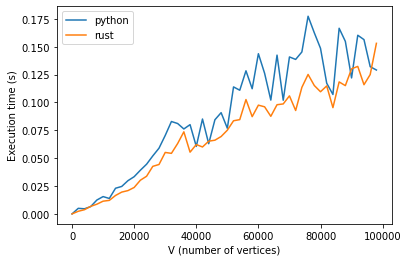

In [6]:
plot(upper=100_000, samples=50, graph_factory="get_linear_graph")

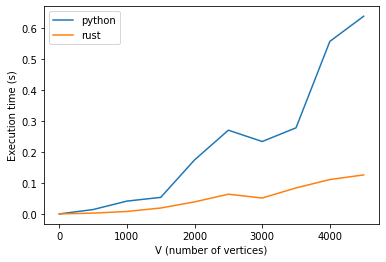

In [7]:
plot(upper=10_000, samples=20, loops=3, graph_factory="get_random_graph")

In [8]:
py_get_ready: List[float] = []
py_done: List[float] = []

rust_get_ready: List[float] = []
rust_done: List[float] = []

for _ in range(10):
    t = setup_python(1_000, get_linear_graph)
    start = timeit.default_timer()
    ready = t.get_ready()
    py_get_ready.append(timeit.default_timer()-start)
    start = timeit.default_timer()
    t.done(*ready)
    py_done.append(timeit.default_timer()-start)

    t = setup_rust(1_000, get_linear_graph)
    start = timeit.default_timer()
    ready = t.get_ready()
    rust_get_ready.append(timeit.default_timer()-start)
    start = timeit.default_timer()
    t.done(*ready)
    rust_done.append(timeit.default_timer()-start)

statistics.mean(py_get_ready),statistics.mean(py_done),statistics.mean(rust_get_ready),statistics.mean(rust_done)

(5.800000508315861e-06,
 3.909999577444978e-06,
 1.2310000238358043e-05,
 1.1049999375245535e-05)

In [9]:
py_get_ready: List[float] = []
py_done: List[float] = []

rust_get_ready: List[float] = []
rust_done: List[float] = []

for _ in range(10):
    t = setup_python(1_000, get_random_graph)
    start = timeit.default_timer()
    ready = t.get_ready()
    py_get_ready.append(timeit.default_timer()-start)
    start = timeit.default_timer()
    t.done(*ready)
    py_done.append(timeit.default_timer()-start)

    t = setup_rust(1_000, get_random_graph)
    start = timeit.default_timer()
    ready = t.get_ready()
    rust_get_ready.append(timeit.default_timer()-start)
    start = timeit.default_timer()
    t.done(*ready)
    rust_done.append(timeit.default_timer()-start)

statistics.mean(py_get_ready),statistics.mean(py_done),statistics.mean(rust_get_ready),statistics.mean(rust_done)

(1.584999954502564e-05,
 0.00010962999949697405,
 6.376999990607147e-05,
 4.02000001486158e-05)